In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
from scipy.sparse import hstack

In [2]:
df = pd.read_csv('preprocessed_twitterdata.csv')
df['cleaned_message'].fillna('', inplace=True)

In [3]:
df['word_count'] = df['cleaned_message'].apply(lambda x: len(x.split()))
y = df['sentiment']
# Map class labels to start from 0 instead of -1
y_adjusted = y.map({-1: 0, 0: 1, 1: 2, 2: 3})


In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_message', 'word_count']], y_adjusted, test_size=0.2, random_state=42)

# Feature Engineering

In [5]:
# Convert text data into TF-IDF vectors with max_features=10000
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_message'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_message'])

# Convert TF-IDF matrices to DataFrames
X_train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate TF-IDF vectors with additional features
X_train_final = pd.concat([X_train_tfidf_df, X_train[['word_count']].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_tfidf_df, X_test[['word_count']].reset_index(drop=True)], axis=1)

In [6]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test_final)

In [8]:
# Calculate accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost model with additional features: {accuracy:.2f}")

Accuracy of the XGBoost model with additional features: 0.64


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Score Testing: {accuracy:.2f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Accuracy Score Testing: 0.64
Confusion Matrix:
[[ 227   90  377   51]
 [  48  447  932   75]
 [  33  178 3623  257]
 [  13   32  856  968]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.30      0.43       745
           1       0.60      0.30      0.40      1502
           2       0.63      0.89      0.73      4091
           3       0.72      0.52      0.60      1869

    accuracy                           0.64      8207
   macro avg       0.66      0.50      0.54      8207
weighted avg       0.65      0.64      0.61      8207



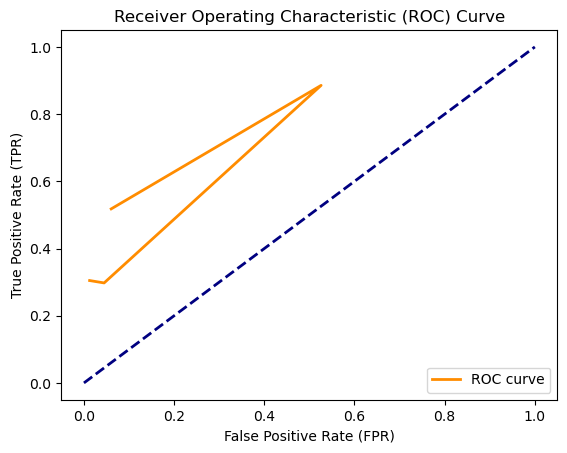

AUC-ROC: -0.03


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Compute True Positive Rate (TPR) and False Positive Rate (FPR)
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

# Plot ROC curve
plt.figure()
plt.plot(FPR, TPR, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate AUC-ROC
AUC_ROC = np.trapz(TPR, FPR)
print(f"AUC-ROC: {AUC_ROC:.2f}")


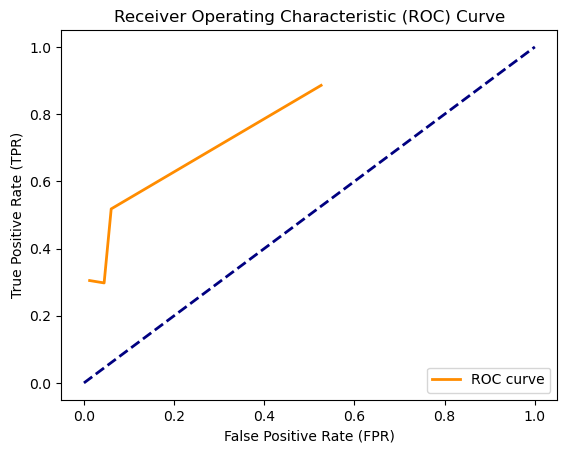

AUC-ROC: 0.34


In [11]:
# Sort TPR and FPR arrays based on ascending order of FPR
sorted_indices = np.argsort(FPR)
TPR_sorted = TPR[sorted_indices]
FPR_sorted = FPR[sorted_indices]

# Plot ROC curve
plt.figure()
plt.plot(FPR_sorted, TPR_sorted, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate AUC-ROC
AUC_ROC = np.trapz(TPR_sorted, FPR_sorted)
print(f"AUC-ROC: {AUC_ROC:.2f}")


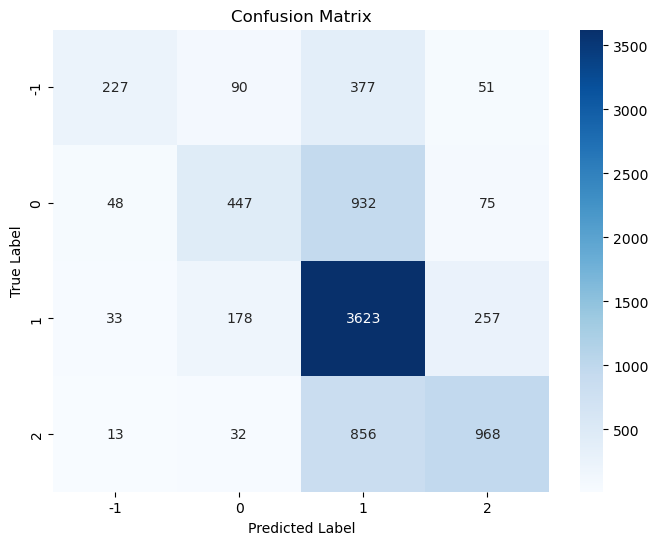

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['-1', '0', '1', '2'], 
            yticklabels=['-1', '0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Random OverSampling

In [13]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [14]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Perform random oversampling on the training data
X_train_ros, y_train_ros = ros.fit_resample(X_train_final, y_train)

# class distribution after oversampling
print("Class distribution after random oversampling:", Counter(y_train_ros))


Class distribution after random oversampling: Counter({3: 16508, 2: 16508, 1: 16508, 0: 16508})


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Train the model on the oversampled data
model.fit(X_train_ros, y_train_ros)

# Make predictions on the test set
y_pred = model.predict(X_test_final)

# Calculate accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after random oversampling: {accuracy:.2f}")

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report after random oversampling:")
print(class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix after random oversampling:")
print(conf_matrix)

Accuracy after random oversampling: 0.59
Classification Report after random oversampling:
              precision    recall  f1-score   support

           0       0.40      0.51      0.45       745
           1       0.43      0.50      0.46      1502
           2       0.76      0.58      0.65      4091
           3       0.56      0.72      0.63      1869

    accuracy                           0.59      8207
   macro avg       0.54      0.58      0.55      8207
weighted avg       0.62      0.59      0.60      8207

Confusion Matrix after random oversampling:
[[ 382  148  135   80]
 [ 207  752  336  207]
 [ 283  700 2353  755]
 [  92  152  274 1351]]


# Hyperparameter tuning

In [17]:
# Convert text data into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_message'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_message'])

# Concatenate TF-IDF vectors with additional features
X_train_final = hstack([X_train_tfidf, X_train[['word_count']]])
X_test_final = hstack([X_test_tfidf, X_test[['word_count']]])

In [18]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [20]:
# Perform Randomized Search CV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_final, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                                           predictor=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [21]:
# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Make predictions on the test set using the best estimator
y_pred = best_estimator.predict(X_test_final)

In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost model with additional features after hyperparameter tuning: {accuracy:.2f}")

Accuracy of the XGBoost model with additional features after hyperparameter tuning: 0.61


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score Testing: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy Score Testing: 0.61
Confusion Matrix:
[[ 168   70  466   41]
 [  29  321 1104   48]
 [  19  121 3783  168]
 [   9   23 1127  710]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.23      0.35       745
           1       0.60      0.21      0.32      1502
           2       0.58      0.92      0.72      4091
           3       0.73      0.38      0.50      1869

    accuracy                           0.61      8207
   macro avg       0.67      0.44      0.47      8207
weighted avg       0.64      0.61      0.56      8207



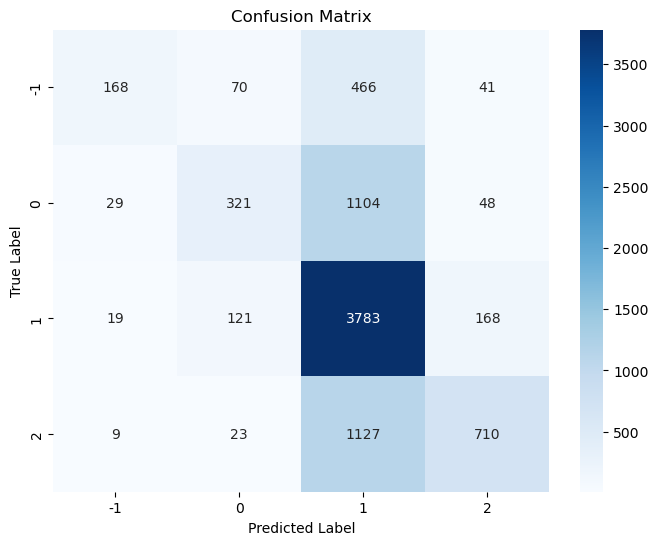

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['-1', '0', '1', '2'], 
            yticklabels=['-1', '0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Word Cloud

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image # for opening, manipulating, and saving many different image file
import warnings
import numpy as np
from ast import literal_eval
import random
import nltk
warnings.filterwarnings('ignore')

In [26]:
!pip install wordcloud

In [27]:
import wordcloud

In [28]:
!pip install gensim
import gensim

In [37]:
df = pd.read_csv('preprocessed_twitterdata.csv')

In [38]:
df['cleaned_message'].fillna('', inplace=True)
message_string = ' '.join(df['cleaned_message'])

In [39]:
from wordcloud import WordCloud

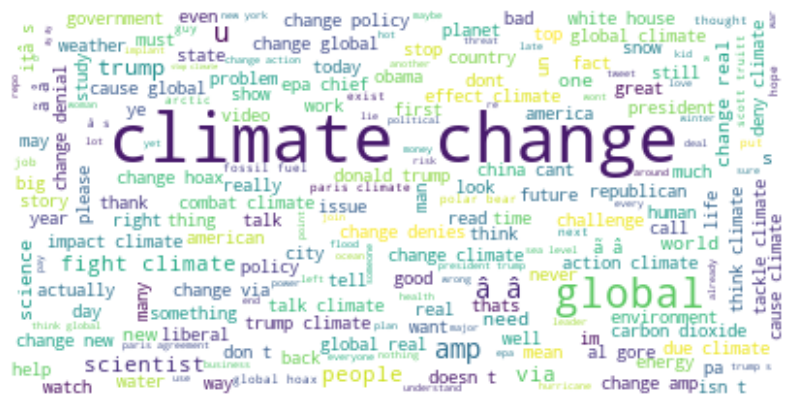

In [40]:
#twitter_mask = np.array(Image.open('twitter.png'))

# Generate the WordCloud with the Twitter mask
#wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(message_string)
wordcloud = WordCloud(background_color="white").generate(message_string)

# Display the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()